# Adding a Gaussian process prior on $\Gamma$

I'm going to add a proper prior to the linewidths, based on the same method used in PBJam.

Remaining caveats are:

- I will not impose a complex prior on mode heights
- I am not accounting for any asphericities due to near-surface magnetic fields

The expected effect of this will be, in order:

- Increased runtime as the mode heights are less constrained
- Possible linewidth broadening or shifting of mode frequencies if there are significant frequency shifts

Things that I've written but not implemented in this example (for speed purposes):

- An asymptotic relation that accounts for curvature to act as a prior on the mode frequency positions.
- A comprehensive background treatment

Instead we are using:

- The literature frequencies and uncertainties. This will speed up the process significantly.
- Dividing the background out and just using a single parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [27]:
target = 3632418
f, p, ff, pp, star, modelocs, elocs, modeids, overtones = read_data(target, 0, -1)

In [28]:
kic = star.KIC
dnu_ = star.dnu
numax_ = star.numax

In [29]:
backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                +str(kic)+'/*_fit.pkl')[0]
with open(backdir, 'rb') as file:
    backfit = pickle.load(file)

labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
res = np.array([np.median(backfit[label]) for label in labels])
res[0:6] = 10**res[0:6]

phi_ = np.array([np.median(backfit[label]) for label in labels])
phi_sigma = pd.DataFrame(backfit)[labels].cov()
phi_cholesky = np.linalg.cholesky(phi_sigma)

model = get_background(ff, *res)
m = get_background(f, *res)
p /= m
pp /= model

In [30]:
f, p = rebin(f, p, 10)

Length: 24150
Length: 1207


(0, 50)

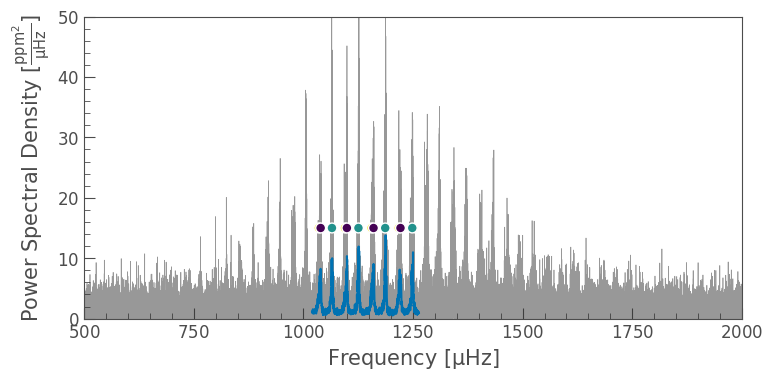

In [31]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
ax = pg.plot(alpha=.5)
ax.plot(f, p)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='w',zorder=100)
ax.set_xlim(500,2000)
ax.set_ylim(0, 50)

In [32]:
class model():
    def __init__(self, f, f0_, f1_, f2_):
        self.f = f
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2
        
    def epsilon(self, i, l, m):
    #We use the prescriptions from Gizon & Solanki 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l, m), 
                                     ws[idx])
  
    def model(self, p):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
                
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
       
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def __call__(self, p):
        return self.model(p)

In [33]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]
n0_ = np.linspace(0., 1., len(f0_))[:,None]
n1_ = np.linspace(0., 1., len(f1_))[:,None]
n2_ = np.linspace(0., 1., len(f2_))[:,None]

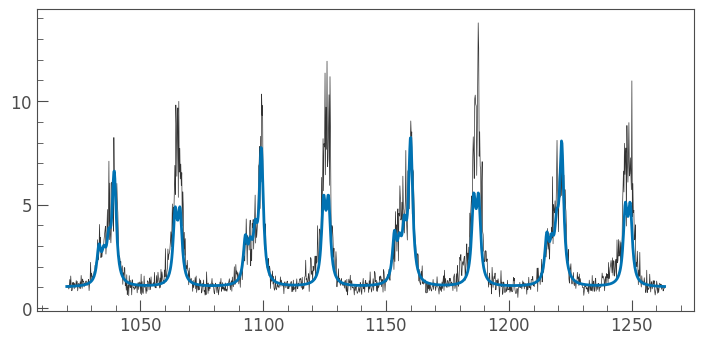

In [34]:
numax = star.numax
init =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0 * np.sin(np.pi/2),       # projected splitting
       np.pi/2.,                    # inclination angle
       1.]                          # background parameter

mod = model(f, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod(init), lw=2)

# Gaussian Process priors

Instead of fitting a complex empirical relation, we'll use a Gaussian Process and marginalise over all functions, and apply this as the prior on the linewidth.

To approximate this relation we will use a squared exponential kernel:

$K_{i, j} = \sigma^2 \times \exp\left(\frac{-(\nu_i - \nu_j)^2}{2L^2}\right)$

where $\nu$ is the frequency and $K$ is the GP kernel, $\sigma$ is the spread and $L$ is the length scale.

We will set the mean of the GP to a straight line but evaluated in log space, so:

$\log_{10}\Gamma = \nu \times c + m$

Where $m$ and $c$ can be free parameters.

We'll apply separate priors for modes of different $l$, but all will have the same length scale, as the variation in frequency should be independent of $l$.

We're going to make a pretty general assumption here to make this work. We don't know the mode frequencies out of hand, but PyMC3 doesn't let us apply a GP onto a space that isn't pre-determined. So instead of applying it onto the latent frequencies, we'll make the assumption that the frequencies are equally spaced *and* that the length scale of the GP is much larger than the variance on the frqeuency positions due to curvature and glitches.

# Build the priors in PyMC3

In [35]:
pm_model = pm.Model()

with pm_model:   
    # Frequencies
    f0 = pm.Normal('f0', mu=f0_, sigma=f0_e, testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=f1_e, testval=f1_, shape=len(f1_))
    f2 = pm.Normal('f2', mu=f2_, sigma=f2_e, testval=f2_, shape=len(f2_))
    
    # Linewidth GP parameters
    m0 = pm.Normal('gradient0', 0, 10)
    m1 = pm.Normal('gradient1', 0, 10)
    m2 = pm.Normal('gradient2', 0, 10)    
    c0 = pm.Normal('intercept0', 0, 10)
    c1 = pm.Normal('intercept1', 0, 10)
    c2 = pm.Normal('intercept2', 0, 10)
    sigma0 = pm.Lognormal('sigma0', np.log(1.0), 1.0)
    sigma1 = pm.Lognormal('sigma1', np.log(1.0), 1.0)
    sigma2 = pm.Lognormal('sigma2', np.log(1.0), 1.0)
    ls = pm.Lognormal('ls', np.log(0.3), 1.0)    
    
    # Setting up the Gaussian Processes
    mu0 = pm.gp.mean.Linear(coeffs=m0, intercept=c0)
    mu1 = pm.gp.mean.Linear(coeffs=m1, intercept=c1)
    mu2 = pm.gp.mean.Linear(coeffs=m2, intercept=c2)
    
    cov0 = sigma0 * pm.gp.cov.ExpQuad(1, ls=ls)
    cov1 = sigma1 * pm.gp.cov.ExpQuad(1, ls=ls)    
    cov2 = sigma2 * pm.gp.cov.ExpQuad(1, ls=ls)    
    
    gp0 = pm.gp.Latent(cov_func = cov0, mean_func=mu0)
    gp1 = pm.gp.Latent(cov_func = cov1, mean_func=mu1)
    gp2 = pm.gp.Latent(cov_func = cov2, mean_func=mu2)  
    
    # Mode linewidths (in log space)
    lng0 = gp0.prior('lng0', X=n0_)
    lng1 = gp1.prior('lng1', X=n1_)
    lng2 = gp2.prior('lng2', X=n2_)
    
    # Modelinewidths (in regular space)
    g0 = pm.Deterministic('g0', pm.math.exp(lng0))
    g1 = pm.Deterministic('g1', pm.math.exp(lng1))
    g2 = pm.Deterministic('g2', pm.math.exp(lng2))   
#     g1 = pm.HalfNormal('g1', sigma=2.0, testval=init[4], shape=len(init[4]))
#     g2 = pm.HalfNormal('g2', sigma=2.0, testval=init[5], shape=len(init[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init[6], shape=len(init[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init[7], shape=len(init[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init[8], shape=len(init[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init[10])
    cosi = pm.Uniform('cosi', 0., 1.)
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background treatment
    b = pm.TruncatedNormal('b', mu=1., sigma=0.1, lower=0., testval=1.)
    
    #Model
    fit = mod([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

In [ ]:
with pm_model:
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, g2, g1, lng0_rotated_, ls, sigma0, intercept0, gradient0, f2, f1, f0]
Sampling 4 chains:  87%|████████▋ | 3486/4000 [01:51<00:13, 37.10draws/s]

In [ ]:
pm.traceplot(trace)
plt.show()

In [ ]:
labels=['xsplit','cosi','i','split', 'b']
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$i$',r'$\delta\nu_{\rm s}$', 'b']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()

In [ ]:
labels=['gradient0','intercept0','ls','sigma0']
chain = np.array([trace[label] for label in labels])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()

In [ ]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

### Now let's plot some output evaluation:

In [ ]:
from pymc3.gp.util import plot_gp_dist

with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    
    plot_gp_dist(ax, trace['g0'], n0_)
    
    plt.scatter(n0_, np.median(trace['g0'],axis=0), s=50, c='dodgerblue')
    plt.xlabel('Relative n')
    plt.show()

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
    res = np.array([np.median(trace[label],axis=0) for label in labels])
    ax.plot(f, mod(res), lw=2)

In [ ]:
import seaborn as sns
sns.distplot(p/mod(res))
sns.distplot(np.random.chisquare(2, size=10000)/2)